In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import nltk
import re
from string import punctuation
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud


In [2]:
# Others
import re
import nltk
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Sklearn library
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# Keras library
import keras.backend as K
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Bidirectional, GRU, SpatialDropout1D
from sklearn.metrics import f1_score
from keras.layers import  BatchNormalization

/usr/local/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


In [3]:
from keras.engine.topology import Layer
class Attention(Layer):
    def __init__(self, attention_size, **kwargs):
        self.attention_size = attention_size
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        # W: (EMBED_SIZE, ATTENTION_SIZE)
        # b: (ATTENTION_SIZE, 1)
        # u: (ATTENTION_SIZE, 1)
        self.W = self.add_weight(name="W_{:s}".format(self.name),
                                 shape=(input_shape[-1], self.attention_size),
                                 initializer="glorot_normal",
                                 trainable=True)
        self.b = self.add_weight(name="b_{:s}".format(self.name),
                                 shape=(input_shape[1], 1),
                                 initializer="zeros",
                                 trainable=True)
        self.u = self.add_weight(name="u_{:s}".format(self.name),
                                 shape=(self.attention_size, 1),
                                 initializer="glorot_normal",
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x, mask=None):
        # input: (BATCH_SIZE, MAX_TIMESTEPS, EMBED_SIZE)
        # et: (BATCH_SIZE, MAX_TIMESTEPS, ATTENTION_SIZE)
        et = K.tanh(K.dot(x, self.W) + self.b)
        # at: (BATCH_SIZE, MAX_TIMESTEPS)
        at = K.softmax(K.squeeze(K.dot(et, self.u), axis=-1))
        if mask is not None:
            at *= K.cast(mask, K.floatx())
        # ot: (BATCH_SIZE, MAX_TIMESTEPS, EMBED_SIZE)
        atx = K.expand_dims(at, axis=-1)
        ot = atx * x
        # output: (BATCH_SIZE, EMBED_SIZE)
        output = K.sum(ot, axis=1)
        return output

    def compute_mask(self, input, input_mask=None):
        return None

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

#### Read data

In [4]:
train_data = pd.read_table("./project2_data/olid-training-v1.0.tsv", sep='\t')
train_data.drop(['id'], axis = 1, inplace = True)

/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [5]:
labels_level_a= pd.read_csv('./project2_data/labels-levela.csv', header=None, names=['id', 'label_a'])
labels_level_b= pd.read_csv('./project2_data/labels-levelb.csv', header=None, names=['id', 'label_b'])
labels_level_c= pd.read_csv('./project2_data/labels-levelc.csv', header=None, names=['id', 'label_c'])

labels_level_a_dict = dict(zip(labels_level_a.id, labels_level_a.label_a))
labels_level_b_dict = dict(zip(labels_level_b.id, labels_level_b.label_b))
labels_level_c_dict = dict(zip(labels_level_c.id, labels_level_c.label_c))

In [6]:
test_data_a = pd.read_table("./project2_data/testset-levela.tsv", sep='\t')
test_data_b = pd.read_table("./project2_data/testset-levelb.tsv", sep='\t')
test_data_c = pd.read_table("./project2_data/testset-levelc.tsv", sep='\t')

/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  
/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
def labelizeTestData(test_data):
    test_data['subtask_a'] = test_data.apply(lambda row: labels_level_a_dict[row.id] if row.id in labels_level_a_dict else None, axis=1)
    test_data['subtask_b'] = test_data.apply(lambda row: labels_level_b_dict[row.id] if row.id in labels_level_b_dict else None, axis=1)
    test_data['subtask_c'] = test_data.apply(lambda row: labels_level_c_dict[row.id] if row.id in labels_level_c_dict else None, axis=1)
    test_data.drop(['id'], axis = 1, inplace = True)
    return test_data

In [8]:
test_data_a = labelizeTestData(test_data_a)
test_data_b = labelizeTestData(test_data_b)
test_data_c = labelizeTestData(test_data_c)

In [9]:
overall_dataset = pd.concat([train_data, test_data_a, test_data_b, test_data_c])
overall_dataset.reset_index(drop=True, inplace=True)
print(overall_dataset['subtask_a'].value_counts())
print(overall_dataset['subtask_b'].value_counts())
print(overall_dataset['subtask_c'].value_counts())

NOT    9460
OFF    5093
Name: subtask_a, dtype: int64
TIN    4515
UNT     578
Name: subtask_b, dtype: int64
IND    2707
GRP    1308
OTH     500
Name: subtask_c, dtype: int64


In [10]:
overall_dataset.head()

,tweet,subtask_a,subtask_b,subtask_c
0,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


#### Data preprocessing

In [11]:
overall_dataset_task_a = pd.concat([train_data, test_data_a])
overall_dataset_task_b = pd.concat([train_data, test_data_b])
overall_dataset_task_c = pd.concat([train_data, test_data_c])

In [12]:
print(len(overall_dataset_task_a))
print(len(overall_dataset_task_b))
print(len(overall_dataset_task_c))

14100
13480
13453


In [13]:
def getTrainDataIdx(train_data, task):
    train_data_copy = train_data.copy()
    train_data_copy.dropna(subset = [task], inplace = True, axis = 0)
    return len(train_data_copy)

In [14]:
train_data_task_a_idx = getTrainDataIdx(train_data, 'subtask_a')
train_data_task_b_idx = getTrainDataIdx(train_data, 'subtask_b')
train_data_task_c_idx = getTrainDataIdx(train_data, 'subtask_c')

In [15]:
print(train_data_task_a_idx)
print(train_data_task_b_idx)
print(train_data_task_c_idx)

13240
4400
3876


In [16]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import symspell_python as spell_checkers

In [17]:
cDict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cDict.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cDict[match.group(0)]
    return c_re.sub(replace, text)

In [19]:
def dataPreprocessing(dataset, task):
    dataset.dropna(subset = [task], inplace = True, axis = 0)
    dataset['raw_tweet'] = dataset['tweet']
    dataset['tweet'] = dataset['tweet'].apply(lambda x: x.replace("’","'")) 
    dataset['tweet'] = dataset['tweet'].apply(lambda x: expandContractions(x))
    dataset['tweet'] = dataset['tweet'].apply(lambda x: x.lower())
    #remove url, hashtags
    dataset['tweet'] = dataset['tweet'].apply(lambda x: ' '.join(re.sub(r"(@[A-Za-z0-9]+)|^rt |(#[A-Za-z0-9]+) |(\w+:\/*\S+)|[^a-zA-Z\s]","",x).split()))
    dataset['tweet'] = dataset['tweet'].apply(lambda x: x.replace('url',''))
    # lemmatisation
    tokeniser = TweetTokenizer()
    wordnet_lemmatizer = WordNetLemmatizer()
    dataset['tweet'] = dataset['tweet'].apply(lambda x: [word for word in tokeniser.tokenize(x)])
    
        #spell check
    spell_checkers.create_dictionary("./eng_dict.txt")
    print("Spell checking...")
    for i in range(len(dataset['tweet'])):
        try:
            #print('%i out of %i' % (i, len(dataset['tweet'])))
            for j in range(len(dataset['tweet'][i])):
                suggs = spell_checkers.get_suggestions(dataset['tweet'][i][j])
                if suggs:
                    best_sugg = str(suggs[0])
                    dataset['tweet'][i][j] = best_sugg
        except:
            continue
            
    dataset['tweet'] = dataset['tweet'].apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word, pos = "v") for word in x]))
    
    return dataset
    

In [20]:
dataset_task_a = dataPreprocessing(overall_dataset_task_a, 'subtask_a')
dataset_task_a.head()

Creating dictionary...
total words processed: 223118
total unique words in corpus: 223118
total items in dictionary (corpus words and deletions): 6778287
  edit distance for deletions: 3
  length of longest word in corpus: 15
Spell checking...
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary withi

,tweet,subtask_a,subtask_b,subtask_c,raw_tweet
0,she should ask a few native americans what the...,OFF,UNT,NaN,@USER She should ask a few native Americans wh...
1,go home you be drink,OFF,TIN,IND,@USER @USER Go home you’re drunk!!! @USER #MAG...
2,amazon be investigate chinese employees who be...,NOT,NaN,NaN,Amazon is investigating Chinese employees who ...
3,someone should havetaken this piece of shit to...,OFF,UNT,NaN,"@USER Someone should'veTaken"" this piece of sh..."
4,obama want liberals amp illegals to move into ...,NOT,NaN,NaN,@USER @USER Obama wanted liberals &amp; illega...


In [21]:
dataset_task_b = dataPreprocessing(overall_dataset_task_b, 'subtask_b')
dataset_task_b.head()

Creating dictionary...
total words processed: 223118
total unique words in corpus: 223118
total items in dictionary (corpus words and deletions): 6778287
  edit distance for deletions: 3
  length of longest word in corpus: 15
Spell checking...
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary withi

,tweet,subtask_a,subtask_b,subtask_c,raw_tweet
0,she should ask a few native americans what the...,OFF,UNT,NaN,@USER She should ask a few native Americans wh...
1,go home you be drink,OFF,TIN,IND,@USER @USER Go home you’re drunk!!! @USER #MAG...
3,someone should havetaken this piece of shit to...,OFF,UNT,NaN,"@USER Someone should'veTaken"" this piece of sh..."
5,liberals be all kookoo,OFF,TIN,OTH,@USER Liberals are all Kookoo !!!
6,oh noes tough shit,OFF,UNT,NaN,@USER @USER Oh noes! Tough shit.


In [22]:
dataset_task_c = dataPreprocessing(overall_dataset_task_c, 'subtask_c')
dataset_task_c.head()

Creating dictionary...
total words processed: 223118
total unique words in corpus: 223118
total items in dictionary (corpus words and deletions): 6778287
  edit distance for deletions: 3
  length of longest word in corpus: 15
Spell checking...
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary within maximum edit distance
no items in dictionary withi

,tweet,subtask_a,subtask_b,subtask_c,raw_tweet
1,go home you be drink,OFF,TIN,IND,@USER @USER Go home you’re drunk!!! @USER #MAG...
5,liberals be all kookoo,OFF,TIN,OTH,@USER Liberals are all Kookoo !!!
7,be literally just talk about this lol all mass...,OFF,TIN,GRP,@USER was literally just talking about this lo...
9,canada do not need another cuck we already hav...,OFF,TIN,IND,@USER Canada doesn’t need another CUCK! We alr...
12,you be a lie corrupt traitor nobody want to he...,OFF,TIN,IND,@USER you are a lying corrupt traitor!!! Nobod...


In [23]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#### Training data preparation

In [24]:
def dataPreparation(X, y, num_classes):
    # Create train_sequences
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X)
    vocabulary_size = len(tokenizer.word_counts) + 1
    train_sequences = tokenizer.texts_to_sequences(X)
    train_data = pad_sequences(train_sequences, maxlen=50)
    
    # Encode class values as integers
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_train_labels = encoder.transform(y)
    print(encoder.classes_)
    if num_classes > 2:
        encoded_train_labels = np_utils.to_categorical(encoded_train_labels)
    
    return train_data, encoded_train_labels, tokenizer, vocabulary_size
    

In [25]:
train_data_task_a, train_data_labels_task_a, tokenizer_task_a, size_of_vocab_task_a = \
    dataPreparation(dataset_task_a['tweet'] , dataset_task_a['subtask_a'], len(np.unique(dataset_task_a['subtask_a'])))

train_data_task_b, train_data_labels_task_b, tokenizer_task_b, size_of_vocab_task_b = \
    dataPreparation(dataset_task_b['tweet'] , dataset_task_b['subtask_b'], len(np.unique(dataset_task_b['subtask_b'])))


train_data_task_c, train_data_labels_task_c, tokenizer_task_c, size_of_vocab_task_c = \
    dataPreparation(dataset_task_c['tweet'] , dataset_task_c['subtask_c'], len(np.unique(dataset_task_c['subtask_c'])))


['NOT' 'OFF']
['TIN' 'UNT']
['GRP' 'IND' 'OTH']


In [26]:
def trainTestDataSplit(train_data, train_data_labels, train_data_idx):
    X_train = train_data[:train_data_idx]
    X_test = train_data[train_data_idx:]
    y_train = train_data_labels[:train_data_idx]
    y_test = train_data_labels[train_data_idx:]
    return X_train, y_train, X_test, y_test

In [27]:
X_train_task_a, y_train_task_a, X_test_task_a, y_test_task_a = \
    trainTestDataSplit(train_data_task_a, train_data_labels_task_a, train_data_task_a_idx)

X_train_task_b, y_train_task_b, X_test_task_b, y_test_task_b = \
    trainTestDataSplit(train_data_task_b, train_data_labels_task_b, train_data_task_b_idx)

X_train_task_c, y_train_task_c, X_test_task_c, y_test_task_c = \
    trainTestDataSplit(train_data_task_c, train_data_labels_task_c, train_data_task_c_idx)

#### Build model

##### subtask_a

In [28]:
model_parameters_subtask_a = {'epochs': 5,
                        'classes':                          np.unique(dataset_task_a['subtask_a']),
                        'num_classes':                      len(np.unique(dataset_task_a['subtask_a'])),
                        'tokenizer':                        tokenizer_task_a,
                        'vocab_size':                       size_of_vocab_task_a,
                        'optimizer':                       'adam',
                        'use_pretrained_embedding':         True,
                        'model_type':                       'BiGRU-CNN',
                    }

In [41]:
class model_for_subtask_a():
    def __init__(self, model_parameters):
        self.hparams = model_parameters
        if self.hparams['use_pretrained_embedding'] == True:
            self.load_build_embeddings()
    def load_build_embeddings(self):
        print('Load pretrained embedding ...')
        embeddings_index = dict()
        f = open('glove.42B.300d.txt')
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        embedding_matrix = np.zeros((self.hparams['vocab_size'], 300))
        
        for word, index in self.hparams['tokenizer'].word_index.items():
            if index > self.hparams['vocab_size'] - 1:
                break
            else:
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    embedding_matrix[index] = embedding_vector    
        
        self.embedding_matrix = embedding_matrix
        
    def build_model(self, optimizer = 'adam'):
        model = Sequential()
        if self.hparams['use_pretrained_embedding'] == True:
            model.add(Embedding(self.hparams['vocab_size'], 300, input_length=50, weights=[self.embedding_matrix], trainable=False))
        else:
            model.add(Embedding(self.hparams['vocab_size'], 100, input_length=50))
        
        if self.hparams['model_type'] == 'BiGRU-CNN':
            model.add(Bidirectional(GRU(300, return_sequences = True, dropout=0.35, recurrent_dropout=0.35)))
            model.add(Conv1D(128, 5, activation='relu'))
            model.add(MaxPooling1D(pool_size=5))
            model.add(Conv1D(128, 5, activation='relu'))
            model.add(MaxPooling1D(pool_size=5))
            model.add(Flatten())
            model.add(Dense(128, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(1, activation='sigmoid'))
            
        elif self.hparams['model_type'] == 'CNN':
            model.add(Conv1D(128, 5, activation='relu'))
            model.add(MaxPooling1D(pool_size=5))
            model.add(Conv1D(128, 5, activation='relu'))
            model.add(MaxPooling1D(pool_size=5))
            model.add(Flatten())
            model.add(Dense(128, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(1, activation='sigmoid'))
        elif self.hparams['model_type'] == 'BiGRU-attention':
            model.add(Bidirectional(GRU(300, return_sequences = True, dropout=0.35, recurrent_dropout=0.35)))
            model.add(Attention(300))
            model.add(Dense(128, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(1, activation='sigmoid'))

        self.model = model
        self.model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])
        #self.model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])
        model.summary()
        return model
    
    def train(self, X_train_val, y_train_val, computed_weights = None, callbacks = None):
        self.model.fit(X_train_val, y_train_val, validation_split = 0.25, epochs = self.hparams['epochs'], class_weight = computed_weights, callbacks=callbacks)
        
    def evaluate(self, X_test, y_test):        
        predictions = self.model.predict(X_test)
        predictions_round = [np.round(x) for x in predictions]
        print(classification_report(y_test, np.array(predictions_round)))
        print("f1_score:")
        print(f1_score(y_true= (y_test), y_pred=np.array(predictions_round), average='macro'))
        
        def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
            """
            This function prints and plots the confusion matrix.
            """
            
            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title(title)
            plt.colorbar()
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=45)
            plt.yticks(tick_marks, classes)
        
            fmt = 'd'
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], fmt),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
        
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.tight_layout()
        cnf_matrix = confusion_matrix(y_test, np.array(predictions_round))
        plot_confusion_matrix(cnf_matrix, classes = self.hparams['classes'], title = 'Confusion matrix')
        plt.show()
        
    def save_model(self, model_file_path):
        self.model.save(model_file_path)
    

Load pretrained embedding ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 50, 300)           4383600   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 50, 600)           1081800   
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 46, 128)           384128    
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 5, 128)            82048     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 128)      

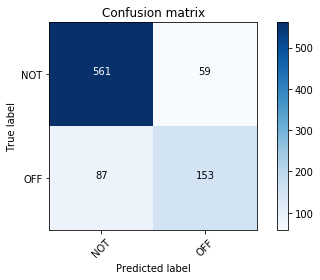

In [45]:
model_parameters_subtask_a['model_type'] = 'BiGRU-CNN'
model_parameters_subtask_a['epochs'] = 5
model_parameters_subtask_a['use_pretrained_embedding'] = True
model_subtask_a = model_for_subtask_a(model_parameters_subtask_a)
# build model
model_subtask_a.build_model()
# train
model_subtask_a.train(X_train_task_a, y_train_task_a)
# evaluate
model_subtask_a.evaluate(X_test_task_a, y_test_task_a)
# save
model_subtask_a.save_model('./models/subtask_a/BiGRU-CNN_with_emb.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 50, 100)           1461200   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 50, 600)           721800    
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 46, 128)           384128    
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 5, 128)            82048     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 128)               0         
__________

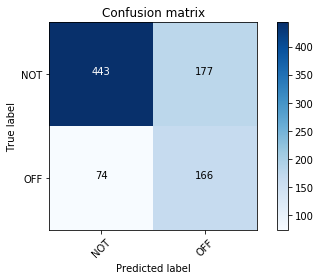

In [44]:
model_parameters_subtask_a['model_type'] = 'BiGRU-CNN'
model_parameters_subtask_a['epochs'] = 5
model_parameters_subtask_a['use_pretrained_embedding'] = False
model_subtask_a = model_for_subtask_a(model_parameters_subtask_a)
# build model
model_subtask_a.build_model()
# train
model_subtask_a.train(X_train_task_a, y_train_task_a)
# evaluate
model_subtask_a.evaluate(X_test_task_a, y_test_task_a)
# save
model_subtask_a.save_model('./models/subtask_a/BiGRU-CNN.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 100)           1461200   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 46, 128)           64128     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 5, 128)            82048     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
__________

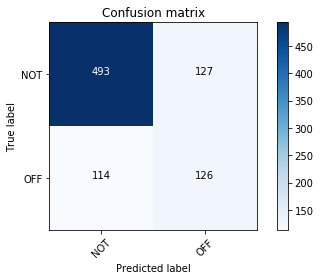

In [39]:
model_parameters_subtask_a['model_type'] = 'CNN'
model_parameters_subtask_a['epochs'] = 3
model_parameters_subtask_a['use_pretrained_embedding'] = False
model_subtask_a = model_for_subtask_a(model_parameters_subtask_a)
# build model
model_subtask_a.build_model()
# train
model_subtask_a.train(X_train_task_a, y_train_task_a)
# evaluate
model_subtask_a.evaluate(X_test_task_a, y_test_task_a)
# save
model_subtask_a.save_model('./models/subtask_a/CNN.h5')

Load pretrained embedding ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 300)           4383600   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 50, 600)           1081800   
_________________________________________________________________
attention_3 (Attention)      (None, 600)               180350    
_________________________________________________________________
dense_15 (Dense)             (None, 128)               76928     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 129       
Total params: 5,722,807
Trainable params: 1,339,207
Non-trainable params: 4,383,600
____________________________

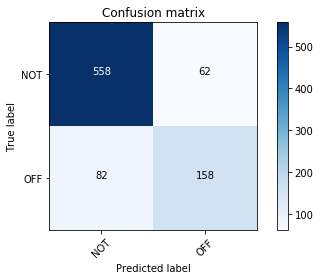

In [43]:
model_parameters_subtask_a['model_type'] = 'BiGRU-attention'
model_parameters_subtask_a['epochs'] = 5
model_parameters_subtask_a['use_pretrained_embedding'] = True
model_subtask_a = model_for_subtask_a(model_parameters_subtask_a)
# build model
model_subtask_a.build_model()
# train
model_subtask_a.train(X_train_task_a, y_train_task_a)
# evaluate
model_subtask_a.evaluate(X_test_task_a, y_test_task_a)
# save
model_subtask_a.save_model('./models/subtask_a/BiGRU-attention.h5')

##### subtask_b

In [48]:
model_parameters_subtask_b = {'epochs': 5,
                        'classes':                          np.unique(dataset_task_b['subtask_b']),
                        'num_classes':                      len(np.unique(dataset_task_b['subtask_b'])),
                        'tokenizer':                        tokenizer_task_b,
                        'vocab_size':                       size_of_vocab_task_b,
                        'optimizer':                       'adam',
                        'use_pretrained_embedding':         True,
                        'model_type':                       'BiGRU-CNN',
                    }

In [49]:
class model_for_subtask_b():
    def __init__(self, model_parameters):
        self.hparams = model_parameters
        if self.hparams['use_pretrained_embedding'] == True:
            self.load_build_embeddings()
    def load_build_embeddings(self):
        print('Load pretrained embedding ...')
        embeddings_index = dict()
        f = open('glove.42B.300d.txt')
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        embedding_matrix = np.zeros((self.hparams['vocab_size'], 300))
        
        for word, index in self.hparams['tokenizer'].word_index.items():
            if index > self.hparams['vocab_size'] - 1:
                break
            else:
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    embedding_matrix[index] = embedding_vector    
        
        self.embedding_matrix = embedding_matrix
        
    def build_model(self, optimizer = 'adam'):
        model = Sequential()
        if self.hparams['use_pretrained_embedding'] == True:
            model.add(Embedding(self.hparams['vocab_size'], 300, input_length=50, weights=[self.embedding_matrix], trainable=False))
        else:
            model.add(Embedding(self.hparams['vocab_size'], 100, input_length=50))
        
        if self.hparams['model_type'] == 'BiGRU-CNN':
            model.add(Bidirectional(GRU(300, return_sequences = True, dropout=0.35, recurrent_dropout=0.35)))
            model.add(Conv1D(128, 5, activation='relu'))
            model.add(MaxPooling1D(pool_size=5))
            model.add(Conv1D(128, 5, activation='relu'))
            model.add(MaxPooling1D(pool_size=5))
            model.add(Flatten())
            model.add(Dense(128, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(1, activation='sigmoid'))
            
        elif self.hparams['model_type'] == 'CNN':
            model.add(Conv1D(128, 5, activation='relu'))
            model.add(MaxPooling1D(pool_size=5))
            model.add(Conv1D(128, 5, activation='relu'))
            model.add(MaxPooling1D(pool_size=5))
            model.add(Flatten())
            model.add(Dense(128, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(1, activation='sigmoid'))
        elif self.hparams['model_type'] == 'BiGRU-attention':
            model.add(Bidirectional(GRU(300, return_sequences = True, dropout=0.35, recurrent_dropout=0.35)))
            model.add(Attention(300))
            model.add(Dense(128, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(1, activation='sigmoid'))

        self.model = model
        self.model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])
        #self.model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])
        model.summary()
        return model
    
    def train(self, X_train_val, y_train_val, computed_weights = None, callbacks = None):
        self.model.fit(X_train_val, y_train_val, validation_split = 0.25, epochs = self.hparams['epochs'], class_weight = computed_weights, callbacks=callbacks)
        
    def evaluate(self, X_test, y_test):        
        predictions = self.model.predict(X_test)
        predictions_round = [np.round(x) for x in predictions]
        print(classification_report(y_test, np.array(predictions_round)))
        print("f1_score:")
        print(f1_score(y_true= (y_test), y_pred=np.array(predictions_round), average='macro'))
        
        def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
            """
            This function prints and plots the confusion matrix.
            """
            
            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title(title)
            plt.colorbar()
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=45)
            plt.yticks(tick_marks, classes)
        
            fmt = 'd'
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], fmt),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
        
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.tight_layout()
        cnf_matrix = confusion_matrix(y_test, np.array(predictions_round))
        plot_confusion_matrix(cnf_matrix, classes = self.hparams['classes'], title = 'Confusion matrix')
        plt.show()
        
    def save_model(self, model_file_path):
        self.model.save(model_file_path)
    

In [50]:
# SMOTE
print("To counter imbalanced dataset: SMOTE Oversampling...")
sm = SMOTE(random_state=12)
X_train_task_b_smote, y_train_task_b_smote = sm.fit_sample(X_train_task_b, y_train_task_b)

To counter imbalanced dataset: SMOTE Oversampling...


Load pretrained embedding ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 50, 300)           2600400   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 50, 600)           1081800   
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 46, 128)           384128    
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 5, 128)            82048     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 128)      

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.89      1.00      0.94       213
           1       0.00      0.00      0.00        27

    accuracy                           0.89       240
   macro avg       0.44      0.50      0.47       240
weighted avg       0.79      0.89      0.83       240

f1_score:
0.47019867549668876


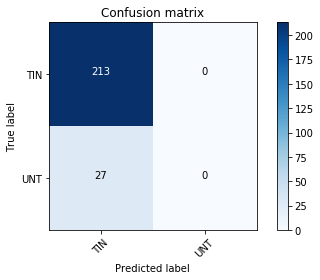

In [51]:
# w/o SMOTE
model_parameters_subtask_b['model_type'] = 'BiGRU-CNN'
model_parameters_subtask_b['epochs'] = 5
model_parameters_subtask_b['use_pretrained_embedding'] = True
model_subtask_b = model_for_subtask_b(model_parameters_subtask_b)
# build model
model_subtask_b.build_model()
# train
model_subtask_b.train(X_train_task_b, y_train_task_b)
# evaluate
model_subtask_b.evaluate(X_test_task_b, y_test_task_b)
# save
model_subtask_b.save_model('./models/subtask_b/BiGRU-CNN_with_emb.h5')

Load pretrained embedding ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 50, 300)           2600400   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 50, 600)           1081800   
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 46, 128)           384128    
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 5, 128)            82048     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 128)      

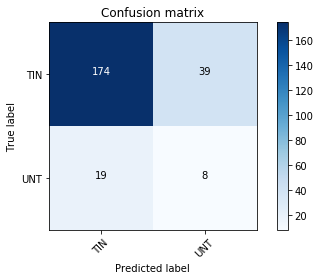

In [53]:
# w/ SMOTE
model_parameters_subtask_b['model_type'] = 'BiGRU-CNN'
model_parameters_subtask_b['epochs'] = 5
model_parameters_subtask_b['use_pretrained_embedding'] = True
model_subtask_b = model_for_subtask_b(model_parameters_subtask_b)
# build model
model_subtask_b.build_model()
# train
model_subtask_b.train(X_train_task_b_smote, y_train_task_b_smote)
# evaluate
model_subtask_b.evaluate(X_test_task_b, y_test_task_b)
# save
model_subtask_b.save_model('./models/subtask_b/BiGRU-CNN_with_emb_smote.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 50, 100)           866800    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 50, 600)           721800    
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 46, 128)           384128    
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 5, 128)            82048     
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 128)               0         
__________

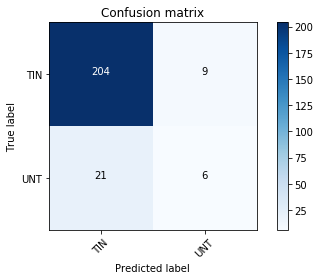

In [54]:
# w/o SMOTE
model_parameters_subtask_b['model_type'] = 'BiGRU-CNN'
model_parameters_subtask_b['epochs'] = 5
model_parameters_subtask_b['use_pretrained_embedding'] = False
model_subtask_b = model_for_subtask_b(model_parameters_subtask_b)
# build model
model_subtask_b.build_model()
# train
model_subtask_b.train(X_train_task_b, y_train_task_b)
# evaluate
model_subtask_b.evaluate(X_test_task_b, y_test_task_b)
# save
model_subtask_b.save_model('./models/subtask_b/BiGRU-CNN.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 50, 100)           866800    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 50, 600)           721800    
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 46, 128)           384128    
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 5, 128)            82048     
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 128)               0         
__________

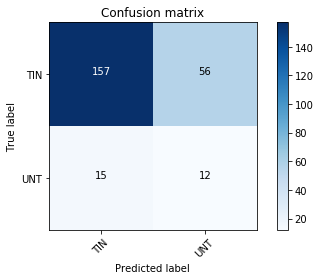

In [55]:
# w/ SMOTE
model_parameters_subtask_b['model_type'] = 'BiGRU-CNN'
model_parameters_subtask_b['epochs'] = 5
model_parameters_subtask_b['use_pretrained_embedding'] = False
model_subtask_b = model_for_subtask_b(model_parameters_subtask_b)
# build model
model_subtask_b.build_model()
# train
model_subtask_b.train(X_train_task_b_smote, y_train_task_b_smote)
# evaluate
model_subtask_b.evaluate(X_test_task_b, y_test_task_b)
# save
model_subtask_b.save_model('./models/subtask_b/BiGRU-CNN_smote.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 50, 100)           866800    
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 46, 128)           64128     
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 5, 128)            82048     
_________________________________________________________________
max_pooling1d_56 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 128)               16512     
__________

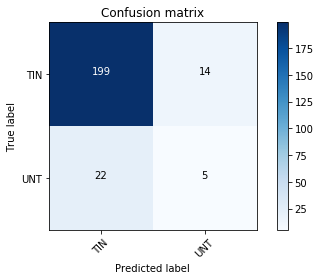

In [72]:
# w/o SMOTE
model_parameters_subtask_b['model_type'] = 'CNN'
model_parameters_subtask_b['epochs'] = 5
model_parameters_subtask_b['use_pretrained_embedding'] = False
model_subtask_b = model_for_subtask_b(model_parameters_subtask_b)
# build model
model_subtask_b.build_model()
# train
model_subtask_b.train(X_train_task_b, y_train_task_b)
# evaluate
model_subtask_b.evaluate(X_test_task_b, y_test_task_b)
# save
model_subtask_b.save_model('./models/subtask_b/CNN.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 50, 100)           866800    
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 46, 128)           64128     
_________________________________________________________________
max_pooling1d_57 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 5, 128)            82048     
_________________________________________________________________
max_pooling1d_58 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 128)               16512     
__________

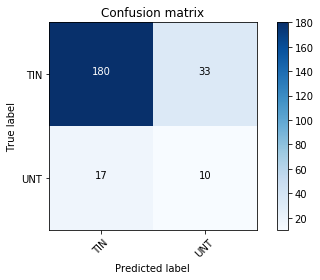

In [73]:
# w/ SMOTE
model_parameters_subtask_b['model_type'] = 'CNN'
model_parameters_subtask_b['epochs'] = 5
model_parameters_subtask_b['use_pretrained_embedding'] = False
model_subtask_b = model_for_subtask_b(model_parameters_subtask_b)
# build model
model_subtask_b.build_model()
# train
model_subtask_b.train(X_train_task_b_smote, y_train_task_b_smote)
# evaluate
model_subtask_b.evaluate(X_test_task_b, y_test_task_b)
# save
model_subtask_b.save_model('./models/subtask_b/CNN_smote.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 50, 100)           866800    
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 50, 600)           721800    
_________________________________________________________________
attention_8 (Attention)      (None, 600)               180350    
_________________________________________________________________
dense_71 (Dense)             (None, 128)               76928     
_________________________________________________________________
dropout_36 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 129       
Total params: 1,846,007
Trainable params: 1,846,007
Non-trainable params: 0
_________________________________________________________________


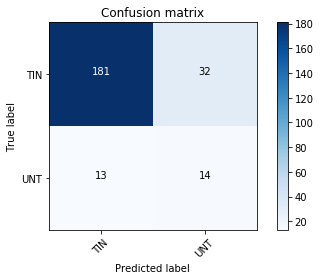

In [76]:
# w/o SMOTE
model_parameters_subtask_b['model_type'] = 'BiGRU-attention'
model_parameters_subtask_b['epochs'] = 5
model_parameters_subtask_b['use_pretrained_embedding'] = False
model_subtask_b = model_for_subtask_b(model_parameters_subtask_b)
# build model
model_subtask_b.build_model()
# train
model_subtask_b.train(X_train_task_b, y_train_task_b)
# evaluate
model_subtask_b.evaluate(X_test_task_b, y_test_task_b)
# save
model_subtask_b.save_model('./models/subtask_b/BiGRU-attention.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, 50, 100)           866800    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 50, 600)           721800    
_________________________________________________________________
attention_9 (Attention)      (None, 600)               180350    
_________________________________________________________________
dense_73 (Dense)             (None, 128)               76928     
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 129       
Total params: 1,846,007
Trainable params: 1,846,007
Non-trainable params: 0
_________________________________________________________________


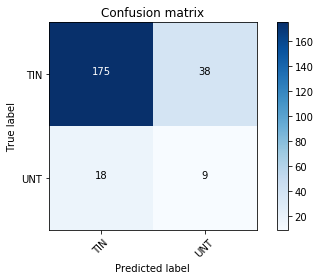

In [77]:
# w/ SMOTE
model_parameters_subtask_b['model_type'] = 'BiGRU-attention'
model_parameters_subtask_b['epochs'] = 5
model_parameters_subtask_b['use_pretrained_embedding'] = False
model_subtask_b = model_for_subtask_b(model_parameters_subtask_b)
# build model
model_subtask_b.build_model()
# train
model_subtask_b.train(X_train_task_b_smote, y_train_task_b_smote)
# evaluate
model_subtask_b.evaluate(X_test_task_b, y_test_task_b)
# save
model_subtask_b.save_model('./models/subtask_b/BiGRU-attention_smote.h5')

##### subtask_c

In [78]:
model_parameters_subtask_c = {'epochs': 5,
                        'classes':                          np.unique(dataset_task_c['subtask_c']),
                        'num_classes':                      len(np.unique(dataset_task_c['subtask_c'])),
                        'tokenizer':                        tokenizer_task_c,
                        'vocab_size':                       size_of_vocab_task_c,
                        'optimizer':                       'adam',
                        'use_pretrained_embedding':         True,
                        'model_type':                       'BiGRU-CNN',
                    }

In [81]:
class model_for_subtask_c():
    def __init__(self, model_parameters):
        self.hparams = model_parameters
        if self.hparams['use_pretrained_embedding'] == True:
            self.load_build_embeddings()
    def load_build_embeddings(self):
        print('Load pretrained embedding ...')
        embeddings_index = dict()
        f = open('glove.42B.300d.txt')
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        embedding_matrix = np.zeros((self.hparams['vocab_size'], 300))
        
        for word, index in self.hparams['tokenizer'].word_index.items():
            if index > self.hparams['vocab_size'] - 1:
                break
            else:
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    embedding_matrix[index] = embedding_vector    
        
        self.embedding_matrix = embedding_matrix
        
    def build_model(self, optimizer = 'adam'):
        model = Sequential()
        if self.hparams['use_pretrained_embedding'] == True:
            model.add(Embedding(self.hparams['vocab_size'], 300, input_length=50, weights=[self.embedding_matrix], trainable=False))
        else:
            model.add(Embedding(self.hparams['vocab_size'], 100, input_length=50))
        
        if self.hparams['model_type'] == 'BiGRU-CNN':
            model.add(Bidirectional(GRU(300, return_sequences = True, dropout=0.35, recurrent_dropout=0.35)))
            model.add(Conv1D(128, 5, activation='relu'))
            model.add(MaxPooling1D(pool_size=5))
            model.add(Conv1D(128, 5, activation='relu'))
            model.add(MaxPooling1D(pool_size=5))
            model.add(Flatten())
            model.add(Dense(128, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(3, activation='softmax'))
            
        elif self.hparams['model_type'] == 'CNN':
            model.add(Conv1D(128, 5, activation='relu'))
            model.add(MaxPooling1D(pool_size=5))
            model.add(Conv1D(128, 5, activation='relu'))
            model.add(MaxPooling1D(pool_size=5))
            model.add(Flatten())
            model.add(Dense(128, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(3, activation='softmax'))
        elif self.hparams['model_type'] == 'BiGRU-attention':
            model.add(Bidirectional(GRU(300, return_sequences = True, dropout=0.35, recurrent_dropout=0.35)))
            model.add(Attention(300))
            model.add(Dense(128, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(3, activation='softmax'))

        self.model = model
        #self.model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])
        self.model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])
        model.summary()
        return model
    
    def train(self, X_train_val, y_train_val, computed_weights = None, callbacks = None):
        self.model.fit(X_train_val, y_train_val, validation_split = 0.25, epochs = self.hparams['epochs'], class_weight = computed_weights, callbacks=callbacks)
        
    def evaluate(self, X_test, y_test):        
        predictions = self.model.predict(X_test)
        predictions_round = [np.round(x) for x in predictions]
        print(classification_report(y_test, np.array(predictions_round)))
        print("f1_score:")
        print(f1_score(y_true= (y_test), y_pred=np.array(predictions_round), average='macro'))
        
        def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
            """
            This function prints and plots the confusion matrix.
            """
            
            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title(title)
            plt.colorbar()
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=45)
            plt.yticks(tick_marks, classes)
        
            fmt = 'd'
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], fmt),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
        
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.tight_layout()
        cnf_matrix = confusion_matrix(y_test.argmax(axis = 1), np.array(predictions_round).argmax(axis = 1))
        plot_confusion_matrix(cnf_matrix, classes = self.hparams['classes'], title = 'Confusion matrix')
        plt.show()
        
    def save_model(self, model_file_path):
        self.model.save(model_file_path)
    

In [760]:
'''
class model_for_subtask_c():
    def __init__(self, model_parameters):
        self.hparams = model_parameters
        if self.hparams['use_pretrained_embedding'] == True:
            self.load_build_embeddings()
    def load_build_embeddings(self):
        print('Load pretrained embedding ...')
        embeddings_index = dict()
        f = open('glove.42B.300d.txt')
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        embedding_matrix = np.zeros((self.hparams['vocab_size'], 300))
        
        for word, index in self.hparams['tokenizer'].word_index.items():
            if index > self.hparams['vocab_size'] - 1:
                break
            else:
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    embedding_matrix[index] = embedding_vector    
        
        self.embedding_matrix = embedding_matrix
        
    def build_model(self, optimizer = 'adam'):
        model = Sequential()
        if self.hparams['use_pretrained_embedding'] == True:
            model.add(Embedding(self.hparams['vocab_size'], 300, input_length=50, weights=[self.embedding_matrix], trainable=False))
        else:
            model.add(Embedding(self.hparams['vocab_size'], 100, input_length=50))
        model.add(Bidirectional(GRU(300, return_sequences = True, dropout=0.35, recurrent_dropout=0.35)))
        model.add(Conv1D(128, 5, activation='relu'))
        model.add(MaxPooling1D(pool_size=5))
        model.add(Conv1D(128, 5, activation='relu'))
        model.add(MaxPooling1D(pool_size=5))
        
        
        
        model.add(Flatten())
        #model.add(LSTM(100, dropout=0.35, recurrent_dropout=0.35))
        #model.add(Bidirectional(LSTM(100, dropout=0.35, recurrent_dropout=0.35)))
        #model.add(GRU(100, dropout=0.35, recurrent_dropout=0.35))
        #model.add(Bidirectional(GRU(100, dropout=0.35, recurrent_dropout=0.35)))
        model.add(Dense(128, activation='relu'))
        #model.add(Flatten())
        model.add(Dropout(0.2))
        #model.add(Dense(1, activation='sigmoid'))
        model.add(Dense(3, activation='softmax'))
        
        self.model = model
        #self.model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])
        self.model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])
        model.summary()
        return model
    
    def train(self, X_train_val, y_train_val, computed_weights = None, callbacks = None):
        self.model.fit(X_train_val, y_train_val, validation_split = 0.25, epochs = self.hparams['epochs'], class_weight = computed_weights, callbacks=callbacks)
        
    def evaluate(self, X_test, y_test):
        score = self.model.evaluate(X_test, y_test)
        print('Test accuracy:', score[1])
        
        predictions = self.model.predict(X_test)
        predictions_round = [np.round(x) for x in predictions]
        print(classification_report(y_test, np.array(predictions_round)))
        print("***************8")
        print(f1_score(y_true= (y_test), y_pred=np.array(predictions_round), average='macro'))
        
        def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
            """
            This function prints and plots the confusion matrix.
            """
            
            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title(title)
            plt.colorbar()
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=45)
            plt.yticks(tick_marks, classes)
        
            fmt = 'd'
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], fmt),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
        
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.tight_layout()
        #cnf_matrix = confusion_matrix(y_test, np.array(predictions_round))
        cnf_matrix = confusion_matrix(y_test.argmax(axis = 1), np.array(predictions_round).argmax(axis = 1))
        plot_confusion_matrix(cnf_matrix, classes = self.hparams['classes'], title = 'Confusion matrix')
        plt.show()
'''    

Load pretrained embedding ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 50, 300)           2447100   
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 50, 600)           1081800   
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 46, 128)           384128    
_________________________________________________________________
max_pooling1d_61 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 5, 128)            82048     
_________________________________________________________________
max_pooling1d_62 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 128)      

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.68      0.63      0.65        78
           1       0.71      0.82      0.76       100
           2       0.00      0.00      0.00        35

   micro avg       0.70      0.62      0.66       213
   macro avg       0.46      0.48      0.47       213
weighted avg       0.58      0.62      0.60       213
 samples avg       0.62      0.62      0.62       213

f1_score:
0.4720413436692506


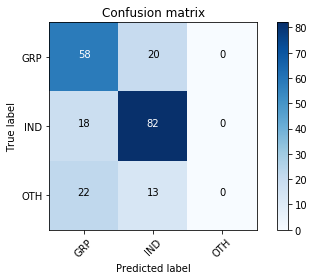

In [82]:
model_parameters_subtask_c['model_type'] = 'BiGRU-CNN'
model_parameters_subtask_c['epochs'] = 5
model_parameters_subtask_c['use_pretrained_embedding'] = True
model_subtask_c = model_for_subtask_c(model_parameters_subtask_c)
# build model
model_subtask_c.build_model()
# train
model_subtask_c.train(X_train_task_c, y_train_task_c)
# evaluate
model_subtask_c.evaluate(X_test_task_c, y_test_task_c)
# save
model_subtask_c.save_model('./models/subtask_c/BiGRU-CNN_with_emb.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_41 (Embedding)     (None, 50, 100)           815700    
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 50, 600)           721800    
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 46, 128)           384128    
_________________________________________________________________
max_pooling1d_63 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 5, 128)            82048     
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 128)               0         
__________

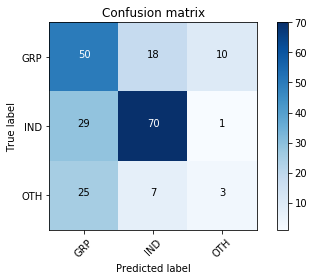

In [83]:
model_parameters_subtask_c['model_type'] = 'BiGRU-CNN'
model_parameters_subtask_c['epochs'] = 5
model_parameters_subtask_c['use_pretrained_embedding'] = False
model_subtask_c = model_for_subtask_c(model_parameters_subtask_c)
# build model
model_subtask_c.build_model()
# train
model_subtask_c.train(X_train_task_c, y_train_task_c)
# evaluate
model_subtask_c.evaluate(X_test_task_c, y_test_task_c)
# save
model_subtask_c.save_model('./models/subtask_c/BiGRU-CNN.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_53 (Embedding)     (None, 50, 100)           815700    
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 46, 128)           64128     
_________________________________________________________________
max_pooling1d_83 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
conv1d_84 (Conv1D)           (None, 5, 128)            82048     
_________________________________________________________________
max_pooling1d_84 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_42 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 128)               16512     
__________

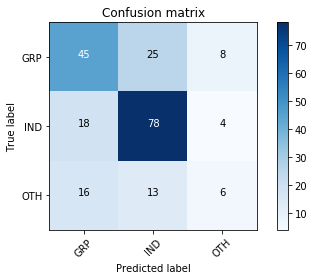

In [95]:
model_parameters_subtask_c['model_type'] = 'CNN'
model_parameters_subtask_c['epochs'] = 8
model_parameters_subtask_c['use_pretrained_embedding'] = False
model_subtask_c = model_for_subtask_c(model_parameters_subtask_c)
# build model
model_subtask_c.build_model()
# train
model_subtask_c.train(X_train_task_c, y_train_task_c)
# evaluate
model_subtask_c.evaluate(X_test_task_c, y_test_task_c)
# save
model_subtask_c.save_model('./models/subtask_c/CNN.h5')

Load pretrained embedding ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_44 (Embedding)     (None, 50, 300)           2447100   
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 50, 600)           1081800   
_________________________________________________________________
attention_11 (Attention)     (None, 600)               180350    
_________________________________________________________________
dense_85 (Dense)             (None, 128)               76928     
_________________________________________________________________
dropout_43 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 3)                 387       
Total params: 3,786,565
Trainable params: 1,339,465
Non-trainable params: 2,447,100
____________________________

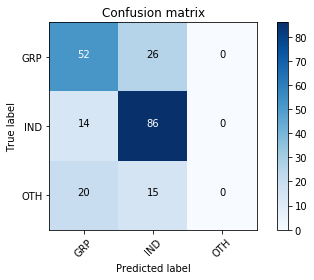

In [86]:
model_parameters_subtask_c['model_type'] = 'BiGRU-attention'
model_parameters_subtask_c['epochs'] = 5
model_parameters_subtask_c['use_pretrained_embedding'] = True
model_subtask_c = model_for_subtask_c(model_parameters_subtask_c)
# build model
model_subtask_c.build_model()
# train
model_subtask_c.train(X_train_task_c, y_train_task_c)
# evaluate
model_subtask_c.evaluate(X_test_task_c, y_test_task_c)
# save
model_subtask_c.save_model('./models/subtask_c/BiGRU-attention.h5')